In [22]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dask.array as da
from scipy import interpolate

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [2]:
os.chdir('/data2/willytsai/python_module/')
import SCAI_calc4obj as scai 

In [3]:
def subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=2,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y%m%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(nlat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                            nlon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[5:16],'%Y%m%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],dim='time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [4]:
def subset_MERRA2(file_path,time_cent,lat_cent,lon_cent,days=2,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y%m%d')
        file = sorted(glob('*'+date_str+'*'))[0]
        data = xr.open_dataset(file)
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
        
        if n == 0: 
            tmp = data; n+=1
        else:
            tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [5]:
def subset_gridsat(file_path,time_cent,lat_cent,lon_cent,days=2,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc)
                            ,lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[11:24],'%Y.%m.%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [6]:
def remove_diurnal_1D(data_all):
    'remove diurnal cycle in the time series [N,time], N cases'
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        tmp = np.fft.fft(data_all[n,:]) # 49
        freqs = np.array(range(NT))   # This gets the left end correct
        reversed_freqs = freqs[::-1]  # Reverse the array 
        reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
        freqs = reversed_freqs[::-1]  # reverse it back 
        tmp[np.where(freqs==6)] = 0 # remove diurnal 6 cycles for 6 days
        tmp[np.where(freqs==12)] = 0 # remove half-day
        tmp[np.where(freqs==11)] = 0
        tmp_re[n,:] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

In [7]:
def center_case(time_event,lon_event,lat_event,cri_r=300,ratio=0.5):
    'precipitation area is enclosed within a circle R at reference time'
    
    file_path = TRMM_dir+'2014_2018'
    time_cent = time_event
    lat_cent = lat_event
    lon_cent = lon_event
    
    # read preciptation data in the given domain
    data = subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=0,lat_inc=2.5,lon_inc=2.5)
    prec_sm = data.precipitation.squeeze()
    prec_sum = np.nansum(prec_sm)

    # calculate the distance matrix
    x,y = np.meshgrid(prec_sm.nlon,prec_sm.nlat)
    dist = np.sqrt((x-lon_cent)**2+(y-lat_cent)**2)*100 # distance from center [km]
    prec_sm.values[dist > cri_r] = 0
    prec_frac = (np.nansum(prec_sm)/prec_sum)
    
    if prec_frac >= ratio:
        result = 1
    else:
        result = 0

    return result

In [8]:
# plt.pcolor(prec_sm.nlon,prec_sm.nlat,prec_sm)
# x,y = np.meshgrid(prec_sm.nlon,prec_sm.nlat)
# dist = np.sqrt((x-lon_event[0])**2+(y-lat_event[0])**2)*100 # distance from center [km]
# plt.contour(prec_sm.nlon,prec_sm.nlat,dist,levels=[200],colors=['r'])

In [9]:
warnings.filterwarnings('ignore')

In [10]:
# ISCCP_dir = '/w2-data/willytsai/ISCCP/hgg/'
# TRMM_dir = '/w2-data2/willytsai/TRMM_3hr/TRMM/'
# MERRA2_dir = '/w2-data2/willytsai/MERRA2/'
# MERRA2_3d_dir = '/w2-data/willytsai/'
# ERA5_dir = '/w2-data/willytsai/ERA5/'
# Gridsat_dir = '/w2-data/willytsai/gridsat_BT/remap_0.25deg/'
# fig_dir = '/w2-data/willytsai/ISCCP/fig/'

ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/data/willytsai/'
ERA5_dir = '/data/willytsai/ERA5/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.25deg/'
fig_dir = '/data/willytsai/ISCCP/fig/'

In [11]:
# load data
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds.dat'))

In [12]:
os.chdir('/data/willytsai/TQUV_3hr/')
files = glob('*.nc')
lev = xr.open_dataset(files[0]).T.lev # MERRA2 standard level 
del files
os.chdir('/data/willytsai/Cloudfrac_3hr/')
lev_m = np.loadtxt('model_lev.txt')[:,1]# MERRA2 model level, 58 levs [72-15]

In [13]:
def event_region(lat_event,lon_event,lon_w,lon_e,lat_s,lat_n):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event <= lon_e))[0]
    idy = np.where(np.logical_and(lat_event >= lat_s, lat_event <= lat_n))[0]
    idc = np.intersect1d(idx,idy)
    return idc

In [14]:
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

In [15]:
time_event = np.asarray(time_event)
lat_event = lat_event
lon_event = lon_event

In [16]:
os.chdir('/data/willytsai/ISCCP/')

prec_all = np.load('prec_all_5deg_4ds.mat.npy')
precM2_all = np.load('precM2_all_5deg_4ds.mat.npy')
cldfrac_all = np.load('cldfrac_all_5deg_4ds.mat.npy')
SCAIbt_all = np.load('SCAIbt_all_5deg_4ds.mat.npy')

crh_all = np.load('crh_all_5deg_4ds.mat.npy')
#cwv_all = np.load('cwv_all_5deg_4ds.mat.npy')
cwvten_ten_all = np.load('cwvten_ten_all_5deg_4ds.mat.npy')
cwvten_dyn_all = np.load('cwvten_dyn_all_5deg_4ds.mat.npy')
cwvten_phy_all = np.load('cwvten_phy_all_5deg_4ds.mat.npy')
cwvten_ana_all = np.load('cwvten_ana_all_5deg_4ds.mat.npy')
LHF_all = np.load('LHF_all_5deg_4ds.mat.npy')
SHF_all = np.load('SHF_all_5deg_4ds.mat.npy')

In [17]:
lat_cen = np.arange(-7.5,10,2.5)
lon_cen = np.arange(-177.5,180,2.5)
idx_record = [] # idx list for final events

for lat in lat_cen:
    for lon in lon_cen:
        idx = np.where(lat_event==lat)[0]
        idy = np.where(lon_event==lon)[0]
        idx_org = np.intersect1d(idx,idy)
        
        time_frame = time_event[idx_org]
        for i,idx in enumerate(idx_org):
            if i == 0:
                if (time_frame[i+1]-time_frame[i]).days >= 4:
                    idx_record.append(idx)
            elif i == len(idx_org)-1:
                if (time_frame[i]-time_frame[i-1]).days >= 4:
                    idx_record.append(idx)
            else:
                if (time_frame[i+1]-time_frame[i]).days >= 4 and \
                   (time_frame[i]-time_frame[i-1]).days >= 4:
                    idx_record.append(idx)            

In [18]:
idx_rm = np.arange(len(time_event))
idx_cld0 = np.where(cldfrac_all[:,16]==0)[0] # cldfrac = 0
idx_scai = np.where(np.isnan(SCAIbt_all[:,16])==1)[0] # SCAI = NaN

idx_rm = np.setdiff1d(idx_rm, idx_cld0) # remove index with all weird cases
idx_rm = np.setdiff1d(idx_rm, idx_scai) # remove index with all weird cases

In [19]:
time_event = time_event[idx_rm]
lat_event = lat_event[idx_rm]
lon_event = lon_event[idx_rm]

crh_all = crh_all[idx_rm,:]
prec_all = prec_all[idx_rm,:]
precM2_all = precM2_all[idx_rm,:]
cldfrac_all = cldfrac_all[idx_rm,:]
SCAIbt_all = SCAIbt_all[idx_rm,:]

cwvten_ten_all = cwvten_ten_all[idx_rm,:]
cwvten_dyn_all = cwvten_dyn_all[idx_rm,:]
cwvten_phy_all = cwvten_phy_all[idx_rm,:]
cwvten_ana_all = cwvten_ana_all[idx_rm,:]
SHF_all = SHF_all[idx_rm,:]
LHF_all = LHF_all[idx_rm,:]

In [25]:
# linear interpolation for MERRA2 flux fields: precM2, SHF, and LHF 

precM2_allre = np.zeros((len(time_event),33))
cwvten_ten_allre = np.copy(precM2_allre)
cwvten_dyn_allre = np.copy(precM2_allre)
cwvten_phy_allre = np.copy(precM2_allre)
cwvten_ana_allre = np.copy(precM2_allre)

for n in range(len(time_event)):
    x = np.linspace(-48,48,32); x2 = np.linspace(-48,48,96)
    xnew = np.linspace(-48,48,33) # interpolating into 3hrly and centered at precip max
    f1 = interpolate.interp1d(x2, cwvten_ten_all[n,:], kind='linear')
    f2 = interpolate.interp1d(x2, cwvten_dyn_all[n,:], kind='linear')
    f3 = interpolate.interp1d(x2, cwvten_phy_all[n,:], kind='linear')
    f4 = interpolate.interp1d(x2, cwvten_ana_all[n,:], kind='linear')
    f5 = interpolate.interp1d(x, precM2_all[n,:], kind='linear')

    cwvten_ten_allre[n,:] = f1(xnew)
    cwvten_dyn_allre[n,:] = f2(xnew)
    cwvten_phy_allre[n,:] = f3(xnew) 
    cwvten_ana_allre[n,:] = f4(xnew)
    precM2_allre[n,:] = f5(xnew)
    
cwvten_ten_all = cwvten_ten_allre; # replace it back
cwvten_phy_all = cwvten_phy_allre; 
cwvten_dyn_all = cwvten_dyn_allre; 
cwvten_ana_all = cwvten_ana_allre; 
precM2_all = precM2_allre; 

In [26]:
# cwvten_ten_all = remove_diurnal_1D(cwvten_ten_all)
# cwvten_dyn_all = remove_diurnal_1D(cwvten_dyn_all)
# cwvten_phy_all = remove_diurnal_1D(cwvten_phy_all)
# cwvten_ana_all = remove_diurnal_1D(cwvten_ana_all)

In [27]:
def idx_group(var1_all,v1_lbound,v1_ubound,var2_all,v2_lbound,v2_ubound):
    
    idx1 = np.where(np.logical_and(var1_all[:,16]>=v1_lbound,var1_all[:,16]<v1_ubound))[0]
    idx2 = np.where(np.logical_and(var2_all[:,16]>=v2_lbound,var2_all[:,16]<v2_ubound))[0]
    idx = np.intersect1d(idx1,idx2)
    
    return idx

In [28]:
# event separation by cloud cover (convective scale) and CRH 
idx_G1 = idx_group(cldfrac_all,0,0.2,crh_all,0,1)
idx_G2 = idx_group(cldfrac_all,0.2,0.4,crh_all,0,1)
idx_G3 = idx_group(cldfrac_all,0.4,0.6,crh_all,0,1)
idx_G4 = idx_group(cldfrac_all,0.6,0.8,crh_all,0,1)
idx_G5 = idx_group(cldfrac_all,0.8,1,crh_all,0,1)

In [29]:
net1 = 24*np.nanmean(cwvten_ten_all,axis=0) # 'mm/day'
net1_p = np.copy(net1); net1_p[net1_p<0] = np.nan
net1_n = np.copy(net1); net1_n[net1_n>0] = np.nan

In [30]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

(-10, 10)

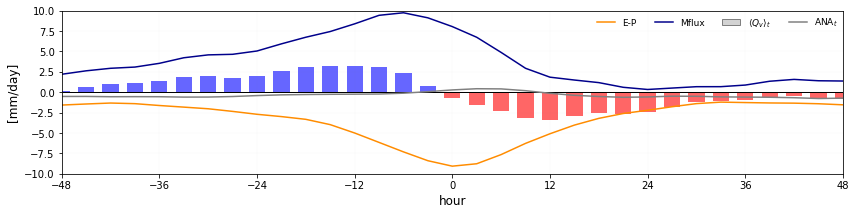

In [32]:
fig = plt.figure(figsize=(14,3))

line1=plt.plot(np.linspace(-48,48,33),24*cwvten_phy_all.mean(axis=0)*3600,color='darkorange')
line2=plt.plot(np.linspace(-48,48,33),24*cwvten_dyn_all.mean(axis=0)*3600,color='darkblue')
plt.bar(np.linspace(-48,48,33),net1_p,color='b',align='center',width=2,alpha=0.6,edgecolor='None')
plt.bar(np.linspace(-48,48,33),net1_n,color='r',align='center',width=2,alpha=0.6,edgecolor='NOne')
plt.plot(np.linspace(-48,48,33),24*cwvten_ana_all.mean(axis=0)*3600,color='grey')
plt.grid(linestyle=':',color='grey',linewidth=0.05);plt.xticks(np.arange(-48,60,12))
plt.hlines(y=0,xmin=-48,xmax=48,linewidth=1)

legend_elements = [Line2D([0], [0], color='darkorange', label='E-P'),
                   Line2D([0], [0], color='darkblue', label='Mflux'),
                   Patch(facecolor='lightgrey', edgecolor='grey',label=r'$\langle Q_v \rangle_t$'),
                   Line2D([0], [0], color='grey', label='ANA$_t$')]
                         
plt.legend(handles=legend_elements,loc=1,
       ncol=4, borderaxespad=0.2, frameon=False, fontsize=9)

plt.rcParams.update({'font.size':10})
plt.ylabel('[mm/day]',fontsize=12);plt.xlabel('hour',fontsize=12)
plt.xlim([-48,48]);plt.ylim([-10,10])
#fig.savefig(fig_dir+'MoistBA_allevents_M2def.pdf',bbox_inches='tight')

In [ ]:
net1 = np.nanmean(cwvten_ten_all[idx_G1,:],axis=0) # 'mm/day'
net1_p = np.copy(net1); net1_p[net1_p<0] = np.nan
net1_n = np.copy(net1); net1_n[net1_n>0] = np.nan

net2 = np.nanmean(cwvten_ten_all[idx_G2,:],axis=0) # 'mm/day'
net2_p = np.copy(net2); net2_p[net2_p<0] = np.nan
net2_n = np.copy(net2); net2_n[net2_n>0] = np.nan

net3 = np.nanmean(cwvten_ten_all[idx_G3,:],axis=0) # 'mm/day'
net3_p = np.copy(net3); net3_p[net3_p<0] = np.nan
net3_n = np.copy(net3); net3_n[net3_n>0] = np.nan

net4 = np.nanmean(cwvten_ten_all[idx_G4,:],axis=0) # 'mm/day'
net4_p = np.copy(net4); net4_p[net4_p<0] = np.nan
net4_n = np.copy(net4); net4_n[net4_n>0] = np.nan

net5 = np.nanmean(cwvten_ten_all[idx_G5,:],axis=0) # 'mm/day'
net5_p = np.copy(net5); net5_p[net5_p<0] = np.nan
net5_n = np.copy(net5); net5_n[net5_n>0] = np.nan

In [ ]:
fig, ax = plt.subplots(5,1,figsize=(10,10)) 

ax[0].plot(np.linspace(-48,48,32),24*cwvten_phy_all[idx_G1,::3].mean(axis=0)*3600,color='darkorange')
ax[0].plot(np.linspace(-48,48,32),24*cwvten_dyn_all[idx_G1,::3].mean(axis=0)*3600,color='g')
ax[0].bar(np.linspace(-48,48,32),24*net1_p[::3],color='b',align='center',width=2,alpha=0.6,edgecolor='None')
ax[0].bar(np.linspace(-48,48,32),24*net1_n[::3],color='r',align='center',width=2,alpha=0.6,edgecolor='NOne')
ax[0].plot(np.linspace(-48,48,32),24*cwvten_ana_all[idx_G1,::3].mean(axis=0)*3600,color='grey')
ax[0].grid(linestyle=':',color='grey',linewidth=0.05);ax[0].set_xticks(np.arange(-48,60,12))

legend_elements = [Line2D([0], [0], color='darkorange', label='E-P'),
                   Line2D([0], [0], color='g', label='Mflux'),
                   Patch(facecolor='lightgrey', edgecolor='grey',label=r'$\langle Q_v \rangle_t$'),
                   Line2D([0], [0], color='grey', label='ANA$_t$')]
                         
ax[0].legend(handles=legend_elements,loc=1,
       ncol=4, borderaxespad=0.2, frameon=False, fontsize=9)

plt.rcParams.update({'font.size':10})
ax[0].set_ylabel('[mm/day]',fontsize=12)
ax[0].set_xlim([-48,48]);ax[0].set_ylim([-10,10])

ax[1].plot(np.linspace(-48,48,32),24*cwvten_phy_all[idx_G2,::3].mean(axis=0)*3600,color='darkorange')
ax[1].plot(np.linspace(-48,48,32),24*cwvten_dyn_all[idx_G2,::3].mean(axis=0)*3600,color='g')
ax[1].bar(np.linspace(-48,48,32),24*net2_p[::3],color='b',align='center',width=2,alpha=0.6,edgecolor='None')
ax[1].bar(np.linspace(-48,48,32),24*net2_n[::3],color='r',align='center',width=2,alpha=0.6,edgecolor='NOne')
ax[1].plot(np.linspace(-48,48,32),24*cwvten_ana_all[idx_G2,::3].mean(axis=0)*3600,color='grey')
ax[1].grid(linestyle=':',color='grey',linewidth=0.05);ax[1].set_xticks(np.arange(-48,60,12))

plt.rcParams.update({'font.size':10})
ax[1].set_ylabel('[mm/day]',fontsize=12)
ax[1].set_xlim([-48,48]);ax[1].set_ylim([-10,10])

ax[2].plot(np.linspace(-48,48,32),24*cwvten_phy_all[idx_G3,::3].mean(axis=0)*3600,color='darkorange')
ax[2].plot(np.linspace(-48,48,32),24*cwvten_dyn_all[idx_G3,::3].mean(axis=0)*3600,color='g')
ax[2].bar(np.linspace(-48,48,32),24*net3_p[::3],color='b',align='center',width=2,alpha=0.6,edgecolor='None')
ax[2].bar(np.linspace(-48,48,32),24*net3_n[::3],color='r',align='center',width=2,alpha=0.6,edgecolor='NOne')
ax[2].plot(np.linspace(-48,48,32),24*cwvten_ana_all[idx_G3,::3].mean(axis=0)*3600,color='grey')
ax[2].grid(linestyle=':',color='grey',linewidth=0.05);ax[2].set_xticks(np.arange(-48,60,12))
plt.rcParams.update({'font.size':10})
ax[2].set_ylabel('[mm/day]',fontsize=12)
ax[2].set_xlim([-48,48]);ax[2].set_ylim([-20,20])

ax[3].plot(np.linspace(-48,48,32),24*cwvten_phy_all[idx_G4,::3].mean(axis=0)*3600,color='darkorange')
ax[3].plot(np.linspace(-48,48,32),24*cwvten_dyn_all[idx_G4,::3].mean(axis=0)*3600,color='g')
ax[3].bar(np.linspace(-48,48,32),24*net4_p[::3],color='b',align='center',width=2,alpha=0.6,edgecolor='None')
ax[3].bar(np.linspace(-48,48,32),24*net4_n[::3],color='r',align='center',width=2,alpha=0.6,edgecolor='NOne')
ax[3].plot(np.linspace(-48,48,32),24*cwvten_ana_all[idx_G4,::3].mean(axis=0)*3600,color='grey')
ax[3].grid(linestyle=':',color='grey',linewidth=0.05);ax[3].set_xticks(np.arange(-48,60,12))
plt.rcParams.update({'font.size':10})
ax[3].set_ylabel('[mm/day]',fontsize=12)
ax[3].set_xlim([-48,48]);ax[3].set_ylim([-20,20])

ax[4].plot(np.linspace(-48,48,32),24*cwvten_phy_all[idx_G5,::3].mean(axis=0)*3600,color='darkorange')
ax[4].plot(np.linspace(-48,48,32),24*cwvten_dyn_all[idx_G5,::3].mean(axis=0)*3600,color='g')
ax[4].bar(np.linspace(-48,48,32),24*net5_p[::3],color='b',align='center',width=2,alpha=0.6,edgecolor='None')
ax[4].bar(np.linspace(-48,48,32),24*net5_n[::3],color='r',align='center',width=2,alpha=0.6,edgecolor='NOne')
ax[4].plot(np.linspace(-48,48,32),24*cwvten_ana_all[idx_G5,::3].mean(axis=0)*3600,color='grey')
ax[4].grid(linestyle=':',color='grey',linewidth=0.05);ax[4].set_xticks(np.arange(-48,60,12))
plt.rcParams.update({'font.size':10})
ax[4].set_ylabel('[mm/day]',fontsize=12);ax[4].set_xlabel('hour',fontsize=12)
ax[4].set_xlim([-48,48]);ax[4].set_ylim([-30,30])

ax[0].set_xticklabels(labels=[]);ax[0].hlines(y=0,xmin=-72,xmax=72,linewidth=0.8)
ax[1].set_xticklabels(labels=[]);ax[1].hlines(y=0,xmin=-72,xmax=72,linewidth=0.8)
ax[2].set_xticklabels(labels=[]);ax[2].hlines(y=0,xmin=-72,xmax=72,linewidth=0.8)
ax[3].set_xticklabels(labels=[]);ax[3].hlines(y=0,xmin=-72,xmax=72,linewidth=0.8)
ax[4].hlines(y=0,xmin=-48,xmax=48,linewidth=0.8)

props = dict(facecolor='white', alpha=0.5)
ax[0].text(-46,6.5,'a',fontsize=14,bbox=props)
ax[1].text(-46,6.5,'b',fontsize=14,bbox=props)
ax[2].text(-46,13,'c',fontsize=14,bbox=props)
ax[3].text(-46,13,'d',fontsize=14,bbox=props)
ax[4].text(-46,19.5,'e',fontsize=14,bbox=props)

In [ ]:
#fig.savefig(fig_dir+'MoistBA_scales_M2def.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.plot(np.linspace(-48,48,32),24*cwvten_ten_all[idx_G1,:].mean(axis=0)[::3],'xk'
         ,markersize=8,markerfacecolor='None')
plt.plot(np.linspace(-48,48,32),24*cwvten_ten_all[idx_G2,:].mean(axis=0)[::3],'or'
         ,markersize=8,markerfacecolor='None')
plt.plot(np.linspace(-48,48,32),24*cwvten_ten_all[idx_G3,:].mean(axis=0)[::3],'^g'
         ,markersize=8,markerfacecolor='None')
plt.plot(np.linspace(-48,48,32),24*cwvten_ten_all[idx_G4,:].mean(axis=0)[::3],'db'
         ,markersize=8,markerfacecolor='None')
plt.plot(np.linspace(-48,48,32),24*cwvten_ten_all[idx_G5,:].mean(axis=0)[::3],'sm'
         ,markersize=8,markerfacecolor='None')
plt.legend(['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1'],fontsize=10,loc=1)
plt.xticks(np.arange(-48,60,12))
plt.hlines(y=0,xmin=-48,xmax=48,linewidth=1);plt.xlim([-48,48])
#plt.vlines(x=0,ymin=-5,ymax=5,linewidth=0.8,color='grey');plt.ylim([-5,5])
plt.xlabel('[hr]',fontsize=14);plt.ylabel('[mm/d]',fontsize=14)

#fig.savefig(fig_dir+'CWVtend_Mbudeget.pdf',bbox_inches='tight')

In [33]:
## sorting SCAI with fixed range of precipitation for consistency
prec_bins2 = np.linspace(5,80,6)

SCAI_deciles_p = np.zeros((len(prec_bins2)-1,10))

for i in range(len(prec_bins2)-1):
    idx = np.where(np.logical_and(24*prec_all[:,16]>=prec_bins2[i],24*prec_all[:,16]<prec_bins2[i+1]))[0]
    SCAI_tmp = SCAIbt_all[idx,16]
    
    # SCAI deciles
    SCAI_deciles_p[i,:] = np.percentile(SCAI_tmp,np.arange(0, 100, 10))

In [34]:
def vars_decile_evo1D(var_all,size=(5,10,33)):
    
    var_dec = np.zeros(size)
    
    for i in range(len(prec_bins2)-1):
        idx = np.where(np.logical_and(24*prec_all[:,16]>=prec_bins2[i],24*prec_all[:,16]<prec_bins2[i+1]))[0]
        SCAI_tmp = SCAIbt_all[idx,16]
        # vars
        var_tmp = var_all[idx,:]
        
        for n in range(10):
            if n < 9:
                idx_dec = np.where(np.logical_and(SCAI_tmp>= SCAI_deciles_p[i,n],SCAI_tmp < SCAI_deciles_p[i,n+1]))[0]
            else:
                idx_dec = np.where(SCAI_tmp>= SCAI_deciles_p[i,n])[0]

            var_dec[i,n] = np.nanmean(var_tmp[idx_dec,:],axis=0)
    
    return var_dec

In [36]:
cwvten_ten_dec = vars_decile_evo1D(cwvten_ten_all,size=(5,10,33))*24 # [mm/d]
cwvten_dyn_dec = vars_decile_evo1D(cwvten_dyn_all,size=(5,10,33))*86400 # [mm/d]
cwvten_phy_dec = vars_decile_evo1D(cwvten_phy_all,size=(5,10,33))*86400 # [mm/d]
cwvten_ana_dec = vars_decile_evo1D(cwvten_ana_all,size=(5,10,33))*86400 # [mm/d]

(-48, 48)

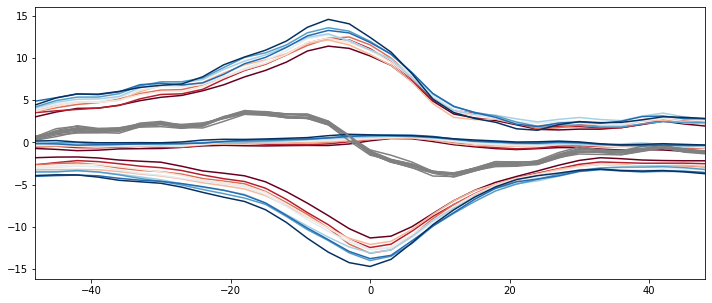

In [43]:
fig = plt.figure(figsize=(12,5))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for n in range(10):
    plt.plot(np.linspace(-48,48,33),cwvten_dyn_dec[2,n,:],color=colors[n])
    plt.plot(np.linspace(-48,48,33),cwvten_phy_dec[2,n,:],color=colors[n])
    plt.plot(np.linspace(-48,48,33),cwvten_ana_dec[2,n,:],color=colors[n])    
    plt.plot(np.linspace(-48,48,33),cwvten_ten_dec[2,n,:],color='grey')        
plt.xlim([-48,48])

In [ ]:
# budget test E-Prec equals to cwvten_phy_all as defined
plt.plot(range(48),LHF_all[idx_G1,:].mean(axis=0)/2.5e6-prec_all[idx_G1,:].mean(axis=0),'k')
plt.plot(range(48),cwvten_phy_all[idx_G1,::3].mean(axis=0),'r')

In [ ]:
tqv_ten = cwv_test[1:,:,:].values-cwv_test[:-1,:,:].values

In [ ]:
plt.plot(tqv_ten[::3,:,:].mean(axis=(1,2)),'k')
plt.plot(dyn_test[::3,:,:].mean(axis=(1,2))*3600,'r')
plt.plot(phy_test[::3,:,:].mean(axis=(1,2))*3600,'g')
plt.plot(ana_test[::3,:,:].mean(axis=(1,2))*3600,'b')
plt.plot(tqv_ten[::3,:,:].mean(axis=(1,2))
         -(dyn_test[::3,:,:]+phy_test[::3,:,:]+ana_test[::3,:,:]).mean(axis=(1,2))*3600,'--')

In [ ]:
# cloud types
os.chdir('/w2-data/willytsai/ISCCP/')
cldamt_cu_all = np.load('cldamt_cu_all_5deg.mat.npy')
cldamt_st_all = np.load('cldamt_st_all_5deg.mat.npy')
cldamt_dc_all = np.load('cldamt_dc_all_5deg.mat.npy')

In [ ]:
cldamt_cu_all = cldamt_cu_all[idx_rm,:]
cldamt_st_all = cldamt_st_all[idx_rm,:]
cldamt_dc_all = cldamt_dc_all[idx_rm,:]

In [ ]:
cldamt_st_g1 = np.nanmean(cldamt_st_all[idx_G1,:],axis=0)
cldamt_st_g3 = np.nanmean(cldamt_st_all[idx_G3,:],axis=0)
cldamt_st_g5 = np.nanmean(cldamt_st_all[idx_G5,:],axis=0)

In [ ]:
plt.plot(range(49),cldamt_st_g1,'k')
plt.plot(range(49),cldamt_st_g3,'b')
plt.plot(range(49),cldamt_st_g5,'r')